<a href="https://colab.research.google.com/github/m-barati/NLP_Shared_Task/blob/main/neural_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
####### IMPORTING AND DOWNLOADING THE NECESSARY LIBARARIES AND MODULES

!pip install transformers
!pip install datasets
!apt install git-lfs
!pip install huggingface-hub
!pip install -q -U keras-tuner
!pip install emoji
!wget https://nlp.stanford.edu/data/glove.twitter.27B.zip
!unzip glove.twitter.27B.zip

     |████████████████████████████████| 4.2 MB 6.1 MB/s 
     |████████████████████████████████| 596 kB 13.5 MB/s 
     |████████████████████████████████| 6.6 MB 38.2 MB/s 
     |████████████████████████████████| 84 kB 2.8 MB/s 
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
     |████████████████████████████████| 342 kB 8.0 MB/s 
     |████████████████████████████████| 136 kB 6.7 MB/s 
     |████████████████████████████████| 1.1 MB 14.1 MB/s 
     |████████████████████████████████| 212 kB 35.6 MB/s 
     |████████████████████████████████| 127 kB 41.5 MB/s 
     |████████████████████████████████| 94 kB 2.8 MB/s 
     |████████████████████████████████| 271 kB 6.8 MB/s 
     |████████████████████████████████| 144 kB 33.8 MB/s 
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.24.3
    Uninstalling urllib3-1.24.3:
      Successfully uninstalled urllib3-1.24.3
ERRO

In [2]:
import pandas as pd
import re
import string
import numpy as np
import csv
import os
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')

import torch
from torch import nn
from torch.nn import functional as F
from torch.optim import Adam
from torch.utils.data import DataLoader, TensorDataset

from tqdm import tqdm
from imblearn import under_sampling

import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('averaged_perceptron_tagger')
from nltk.corpus import stopwords

from sklearn import metrics
from sklearn.metrics import f1_score, classification_report, accuracy_score, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

import tensorflow as tf
from tensorflow import keras
import keras_tuner as kt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import LSTM, Dense, TimeDistributed, Embedding, Bidirectional, Input, SimpleRNN, GlobalMaxPool1D, Dropout, Conv1D, Flatten, BatchNormalization
from tensorflow.keras.models import Model, Sequential

import datasets
from datasets import Dataset, load_metric, load_dataset

from transformers import pipeline, BertTokenizer, BertModel, AutoTokenizer, AutoConfig

import emoji 

from gensim.models.fasttext import FastText
from gensim.test.utils import datapath, get_tmpfile
from gensim.models import KeyedVectors
from gensim.scripts.glove2word2vec import glove2word2vec

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Unzipping corpora/wordnet.zip.
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /root/nltk_data...
[nltk_data]   Unzipping taggers/averaged_perceptron_tagger.zip.


In [3]:
from huggingface_hub import notebook_login
from huggingface_hub import push_to_hub_keras
notebook_login()

Login successful
Your token has been saved to /root/.huggingface/token
Authenticated through git-credential store but this isn't the helper defined on your machine.
You might have to re-authenticate when pushing to the Hugging Face Hub. Run the following command in your terminal in case you want to set this credential helper as the default

git config --global credential.helper store


In [4]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [5]:
data_path = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/NeuralModel/olid-training-v1.0.tsv'

In [6]:
train = pd.read_csv(data_path, sep='\t')
train = train.drop(columns=['subtask_b', 'subtask_c', 'id'])
train.rename(columns = {'tweet':'tweet', 'subtask_a':'label'}, inplace = True)
train.head()

,tweet,label
0,@USER She should ask a few native Americans wh...,OFF
1,@USER @USER Go home you’re drunk!!! @USER #MAG...,OFF
2,Amazon is investigating Chinese employees who ...,NOT
3,"@USER Someone should'veTaken"" this piece of sh...",OFF
4,@USER @USER Obama wanted liberals &amp; illega...,NOT


In [40]:
def remove_noise(data):
  noise = '@USER'
  noise2 = '&amp'
  stops = set(stopwords.words('english'))
  eyes = '[8:=;]'
  nose = "['`\-~]"
  # remove URLs
  data['tweet'] = [re.sub("(?i)\b((?:https?://|www\d{0,3}[.]|[a-z0-9.\-]+[.][a-z]{2,4}/)(?:[^\s()<>]+|\(([^\s()<>]+|(\([^\s()<>]+\)))*\))+(?:\(([^\s()<>]+|(\([^\s()<>]+\)))*\)|[^\s`!()\[\]{};:'\".,<>?«»“”‘’]))", "", tweet) for tweet in data['tweet']]
  # remove '@USER'
  data['tweet'] = [tweet.replace(noise, '') for tweet in data['tweet']]
  data['tweet'] = [tweet.replace(noise2, '') for tweet in data['tweet']]
  # remove punctuation, except apostrophes and hashes. keeping 2+ punctuation (only !, because including ? and . here makes other punctuation remain as well, idk why!)
  data['tweet'] = [re.sub(r'[^\w\d\s\'\#\!{2,}]+', '', tweet) for tweet in data['tweet']]
  # remove digits
  data['tweet'] = data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if not word.isdigit()]))
  # remove stopwords
  data['tweet'] = data['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stops)]))
  # convert non emoji smiley faces & emoticons to words
  data['tweet'] = [re.sub(f'{eyes}{nose}*[)]]+|[[(c]+{nose}*{eyes}', 'smile', tweet) for tweet in data['tweet']]
  data['tweet'] = [re.sub(f'{eyes}{nose}*[pP]+', 'lolface', tweet) for tweet in data['tweet']]
  data['tweet'] = [re.sub(f'{eyes}{nose}*[(c\/]+|[)\/]+{nose}*{eyes}', 'sadface', tweet) for tweet in data['tweet']]
  data['tweet'] = [re.sub(f'{eyes}{nose}*[\|l]+', 'neutralface', tweet) for tweet in data['tweet']]
  data['tweet'] = [re.sub(f'{eyes}{nose}*[oO$s@&]+', 'otherface', tweet) for tweet in data['tweet']]
  data['tweet'] = [re.sub(r'(<3)', 'heart', tweet) for tweet in data['tweet']]
  data['tweet'] = [re.sub(r'(</3)', 'brokenheart', tweet) for tweet in data['tweet']]
  return data

def emojis_to_text(data): 
  # converting emojis to text before tokenizing; one emoji remains one token
  data['tweet'] = [emoji.demojize(tweet) for tweet in data['tweet']]
  return data

def transform(data):
  data['tweet'] = [tweet.lower() for tweet in data['tweet']]

def token_pad(data):
  tokenizer = Tokenizer(num_words= 10000, oov_token = "<oov>")
  tokenizer.fit_on_texts(data)
  txt2seq = tokenizer.texts_to_sequences(data)
  word_index = tokenizer.word_index
  pad_seq = pad_sequences(txt2seq, maxlen = 100, truncating = 'pre', padding = 'post')
  return pad_seq, word_index

def preprocessor(data = train):
  transform(emojis_to_text(remove_noise(data)))
  return data

In [8]:
preprocessor()

X = train['tweet']
train['label'] = np.where(train['label'] == 'NOT', 0, 1)
y = train['label']

X_train, X_test, y_train, y_test = train_test_split(token_pad(X)[0], y, test_size = 0.20, stratify = y)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: FutureWarning: Possible nested set at position 21


In [9]:
### Parsing the vocabulary and embeddings using the 100-dimension embedding glove
word_index = token_pad(X)[1]
max_length = 100

embeddings_index = {}
with open('./glove.twitter.27B.100d.txt','rt') as file: # Opening the file in Reading Text (rt) mode
  for line in file:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs


print('Found %s word vectors.' % len(embeddings_index))

embedding_matrix = np.zeros((len(word_index) + 1, max_length))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros
        embedding_matrix[i] = embedding_vector

Found 1193514 word vectors.


In [ ]:
"""def model_builder():
  input = Input(shape = (max_length, ))
  # create glove embedding layer
  embedding_layer = Embedding(input_dim = len(word_index) + 1,
                            output_dim = max_length,
                            weights = [embedding_matrix],
                            input_length = max_length,
                            trainable = False)(input)
  lstm1 = LSTM(units = 100, return_sequences = True)(embedding_layer)
  drop1 = Dropout(0.6)(lstm1)
  lstm2 = LSTM(units = 50, return_sequences = False)(drop1)
  drop2 = Dropout(0.6)(lstm2)
  flat = Flatten()(drop2)
  dense = Dense(units = 8, activation = 'relu')(flat)
  out = Dense(units = 1, activation = 'sigmoid')(dense)
  model = Model(inputs = input, outputs = out)

  model.compile(optimizer = keras.optimizers.Adam(learning_rate = 0.1),
                loss = keras.losses.SparseCategoricalCrossentropy(from_logits = True),
                metrics = ['accuracy'])
  
  return model"""

In [12]:
def model_builder(hp):
  # create glove embedding layer
  embedding_layer = Embedding(input_dim=len(word_index) + 1,
                            output_dim=max_length,
                            weights=[embedding_matrix],
                            input_length=max_length,
                            trainable=False)
  

  # tune number of units in the first Dense layer
  # choose  optimal value between 32-480
  hp_units = hp.Int('units', min_value=32, max_value=480, step=64)

  # create model
  model = Sequential([
    embedding_layer,
    Bidirectional(LSTM(units=hp_units, return_sequences=True, recurrent_dropout=0.2)),
    GlobalMaxPool1D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(units=hp_units, activation = "relu"),
    Dropout(0.5),
    Dense(16, activation = "relu"),
    Dropout(0.5),
    Dense(2, activation='sigmoid')
    ])


  # tune  learning rate for  optimizer
  # choose  optimal value from 0.01, or 0.001
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3])

  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
                loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
                metrics=['accuracy'])
  
  return model

In [13]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     factor=3,
                     max_epochs=4)

stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

tuner.search(X_train, y_train, epochs=10, validation_split=0.2, callbacks=[stop_early])

# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

Trial 10 Complete [00h 02m 42s]
val_accuracy: 0.7635677456855774

Best val_accuracy So Far: 0.7753657102584839
Total elapsed time: 03h 00m 20s
INFO:tensorflow:Oracle triggered exit

The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is 160 and the optimal learning rate for the optimizer
is 0.001.



In [14]:
model = tuner.hypermodel.build(best_hps)
history = model.fit(X_train, y_train, epochs=30, validation_split=0.2)

valid_acc = history.history['val_accuracy']
best_epoch = valid_acc.index(max(valid_acc)) + 1
print('Best epoch: %d' % (best_epoch,))

Epoch 1/30
265/265 [==============================] - 176s 640ms/step - loss: 0.6784 - accuracy: 0.6491 - val_loss: 0.6423 - val_accuracy: 0.6692
Epoch 2/30
265/265 [==============================] - 182s 688ms/step - loss: 0.5674 - accuracy: 0.7018 - val_loss: 0.5155 - val_accuracy: 0.7291
Epoch 3/30
265/265 [==============================] - 177s 669ms/step - loss: 0.5335 - accuracy: 0.7263 - val_loss: 0.4760 - val_accuracy: 0.7673
Epoch 4/30
265/265 [==============================] - 200s 755ms/step - loss: 0.5088 - accuracy: 0.7458 - val_loss: 0.4872 - val_accuracy: 0.7763
Epoch 5/30
265/265 [==============================] - 188s 710ms/step - loss: 0.5054 - accuracy: 0.7500 - val_loss: 0.4699 - val_accuracy: 0.7820
Epoch 6/30
265/265 [==============================] - 205s 773ms/step - loss: 0.4901 - accuracy: 0.7573 - val_loss: 0.5274 - val_accuracy: 0.7655
Epoch 7/30
265/265 [==============================] - 247s 933ms/step - loss: 0.4825 - accuracy: 0.7624 - val_loss: 0.6052 -

In [16]:
hypermodel = tuner.hypermodel.build(best_hps)

# Retrain the model
hypermodel.fit(X_train, y_train, epochs=15, validation_split=0.2)

Epoch 1/15
265/265 [==============================] - 178s 640ms/step - loss: 0.6968 - accuracy: 0.6372 - val_loss: 0.6161 - val_accuracy: 0.6786
Epoch 2/15
265/265 [==============================] - 168s 635ms/step - loss: 0.5659 - accuracy: 0.7137 - val_loss: 0.5023 - val_accuracy: 0.7537
Epoch 3/15
265/265 [==============================] - 172s 650ms/step - loss: 0.5380 - accuracy: 0.7288 - val_loss: 0.4831 - val_accuracy: 0.7716
Epoch 4/15
265/265 [==============================] - 172s 647ms/step - loss: 0.5084 - accuracy: 0.7532 - val_loss: 0.4749 - val_accuracy: 0.7706
Epoch 5/15
265/265 [==============================] - 172s 650ms/step - loss: 0.5031 - accuracy: 0.7538 - val_loss: 0.4714 - val_accuracy: 0.7754
Epoch 6/15
265/265 [==============================] - 174s 657ms/step - loss: 0.4862 - accuracy: 0.7680 - val_loss: 0.5123 - val_accuracy: 0.7787
Epoch 7/15
265/265 [==============================] - 172s 650ms/step - loss: 0.4888 - accuracy: 0.7657 - val_loss: 0.4651 -

In [17]:
push_to_hub_keras(hypermodel, "SharedTask_Group5_GloVeEmbeddings")

HTTPError: ignored

In [18]:
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_loss = history.history['val_loss']

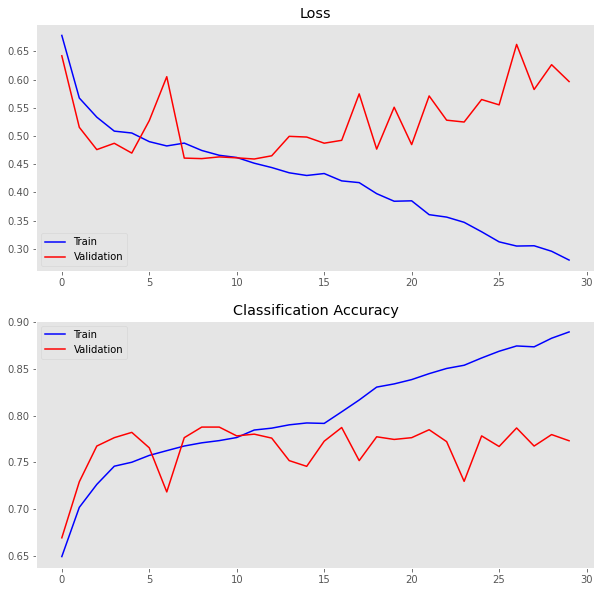

In [19]:
fig=plt.figure(figsize=(10,10))
fig.add_subplot(2, 1, 1)
plt.title('Loss')
plt.grid()
plt.plot(train_loss, color='blue', label='Train')
plt.plot(val_loss, color='red', label='Validation')
plt.legend()
# plot accuracy
fig.add_subplot(2, 1, 2)
plt.title('Classification Accuracy')
plt.grid()
plt.plot(train_acc, color='blue', label='Train')
plt.plot(valid_acc, color='red', label='Validation')
plt.legend()

In [20]:
evaluate = hypermodel.evaluate(X_test, y_test)

print("Test Acuracy is : {:.2f} %".format(evaluate[1]*100))
print("Test Loss is : {:.4f}".format(evaluate[0]))

83/83 [==============================] - 8s 90ms/step - loss: 0.4809 - accuracy: 0.7915
Test Acuracy is : 79.15 %
Test Loss is : 0.4809


In [21]:
predictions = hypermodel.predict(X_test)

predict = []
for i in predictions:
    predict.append(np.argmax(i))

print(predict)

[0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 

In [22]:
cm = confusion_matrix(predict, y_test)
acc = accuracy_score(predict, y_test)

print("The Confusion matrix is: \n",cm)
print(metrics.classification_report(y_test, predict))

The Confusion matrix is: 
 [[1622  406]
 [ 146  474]]
              precision    recall  f1-score   support

           0       0.80      0.92      0.85      1768
           1       0.76      0.54      0.63       880

    accuracy                           0.79      2648
   macro avg       0.78      0.73      0.74      2648
weighted avg       0.79      0.79      0.78      2648



In [41]:
def produce_results(filename, hypermodel = hypermodel):
  test = pd.read_csv(filename)
  preprocessor(data = test)
  id = test['id'].to_list()
  data = test['tweet']
  preds = hypermodel.predict(token_pad(data)[0])
  label = []
  for pred in preds:
    label.append(np.argmax(pred))
  name, ext = os.path.splitext(os.path.basename(filename))
  out_file = '/content/gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/Results/' + name + '_neural' + ext
  output = pd.DataFrame(list(zip(id, label)), columns = ['id', 'label'])
  output['label'] = np.where(output['label'] == 0, 'NOT', 'OFF')
  output.to_csv(out_file, sep=',', encoding='utf-8', index = False)
  gold_file_path = '/content/gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/Results/' + name + '_gold' + ext
  gold = pd.read_csv(gold_file_path, sep=',')
  y_pred = output['label']
  y_test = gold['label']
  print("Accuracy: {}%".format(accuracy_score(y_test, y_pred) * 100))
  print(classification_report(y_test, y_pred))
  cm = confusion_matrix(y_test, y_pred)
  print('Confusion Matrix for ' + name + ': \n' + str(cm))
  ConfusionMatrixDisplay.from_predictions(y_test, y_pred)
  plot = plt.show()
  return

Accuracy: 62.2093023255814%
              precision    recall  f1-score   support

         NOT       0.73      0.75      0.74       620
         OFF       0.31      0.30      0.30       240

    accuracy                           0.62       860
   macro avg       0.52      0.52      0.52       860
weighted avg       0.62      0.62      0.62       860

Confusion Matrix for test_IN: 
[[464 156]
 [169  71]]


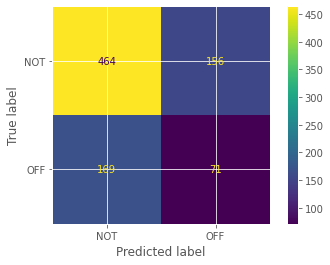

In [42]:
produce_results(filename = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/NeuralModel/test_IN.csv')

Accuracy: 54.681027340513666%
              precision    recall  f1-score   support

         NOT       0.57      0.76      0.65       664
         OFF       0.49      0.29      0.36       543

    accuracy                           0.55      1207
   macro avg       0.53      0.52      0.51      1207
weighted avg       0.53      0.55      0.52      1207

Confusion Matrix for test_OUT1: 
[[503 161]
 [386 157]]


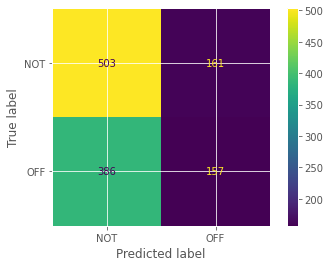

In [43]:
produce_results(filename = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/NeuralModel/test_OUT1.csv')

Accuracy: 40.75%
              precision    recall  f1-score   support

         NOT       0.43      0.55      0.48       600
         OFF       0.37      0.26      0.31       600

    accuracy                           0.41      1200
   macro avg       0.40      0.41      0.39      1200
weighted avg       0.40      0.41      0.39      1200

Confusion Matrix for test_OUT2: 
[[331 269]
 [442 158]]


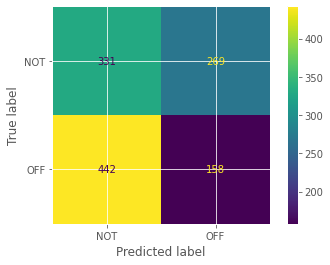

In [44]:
produce_results(filename = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/NeuralModel/test_OUT2.csv')

Accuracy: 64.57680250783699%
              precision    recall  f1-score   support

         NOT       0.84      0.72      0.78      1088
         OFF       0.11      0.21      0.15       188

    accuracy                           0.65      1276
   macro avg       0.48      0.46      0.46      1276
weighted avg       0.73      0.65      0.68      1276

Confusion Matrix for test_TEXTGAIN: 
[[785 303]
 [149  39]]


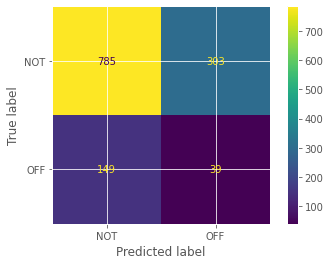

In [45]:
produce_results(filename = 'gdrive/MyDrive/ColabNotebooks/NLP_Files/SharedFolder/NLP/NeuralModel/test_TEXTGAIN.csv')